# Notebook 3: (Demo) Automated batch processing of dose-rate calculations

The batch processing framework shown here may be applied to other procedures, including:
- Pixelization and activity correction
- Alignment
- H&E co-registration

However, it is best to try the procedure with a few sample sets first to optimize the various parameters.

Inputs:
- Simulated MC dose kernel
- Directory of data containing many aligned iQID activity image stacks
- iQID FoV measurement data
- Optional: parameter file for small-value errors introduced by alignment
(comment out pertinent sections if not desired)

Output:
- Central-slice dose-rate images in each subdirectory

In [1]:
# Move the working directory up one level to the one shown to find the source packages.
# Feel free to modify your own system path to accomodate this package if desired.
# Please note this change for all relative paths contained in the notebook.

In [2]:
cd ..

C:\Users\Robin\Documents\Cal\iQID\dev_iqid_alphas


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '18'

from matplotlib.colors import LogNorm
from scipy.ndimage import convolve
from skimage import io
from importlib import reload

from iqid import process, dpk

In [4]:
# get list of substudies in which to perform procedure
# change this to your data directory
rootdir = 'data'
ssl = process.list_substudies(rootdir)

for ss in ssl:
    print(ss)

data\H695\12Aug
data\H695\13Aug
data\H700\25March
data\H700\26March
data\H707\17June
data\H707\18June
data\H714\16Sep
data\H714\17Sep
data\H719\7Oct
data\H719\8Oct
data\H741\2Dec
data\H741\3Dec
data\H751\3Mar
data\H764\PNNL
data\H765\FHCRC
data\H765\PNNL


In [5]:
param_dir = 'parameters'
kern_id = 'at211_10E6_151_1um_water.txt'
scale_id = 'scale_data.csv'
act_corr = 'activity_correction.csv'

In [6]:
# Part 2: Load the dose kernel (MeV) and bin it to the field-of-view scale.
print('Loading Geant4 kernel...')

# Load in the Geant4 kernel and average radially.
dose_kernel = dpk.load_kernel(os.path.join(param_dir, kern_id),
                                dim=151, num_alpha_decays=10e6)
radial_kernel = dpk.radial_avg_kernel(dose_kernel, mode='whole')

# Import the field-of-view data and select our sample study from the list.
# Subpx is the factor used to subpixelate (interpolate) the listmode data.
px, mm, subpx = np.genfromtxt(os.path.join(param_dir, scale_id),
                            delimiter=',', skip_header=1,
                            usecols=(1, 2, 3), unpack=True)
study_slice_z = 12

a_diff = np.genfromtxt(os.path.join(param_dir, act_corr),
                            delimiter=',', skip_header=1,
                            usecols=(2))

a_corr = a_diff/100

# Pad the kernel up to integer multiples of the voxel size.
um_per_px = mm/px * 1e3 / subpx

eff_4pi = 4.25/4.32
eff_2pi = 0.5*eff_4pi
efficiency_factor = 1/eff_2pi
time_snapshot = 1  # second

Loading Geant4 kernel...


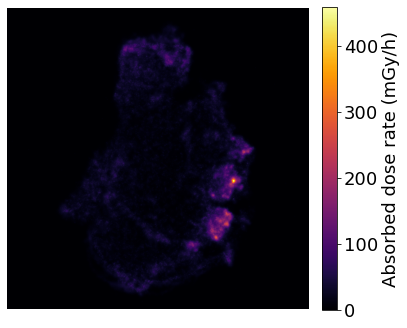

complete:
data\H695\12Aug



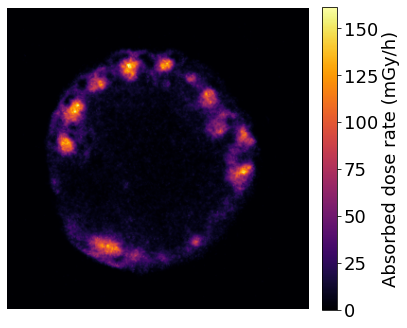

complete:
data\H695\13Aug



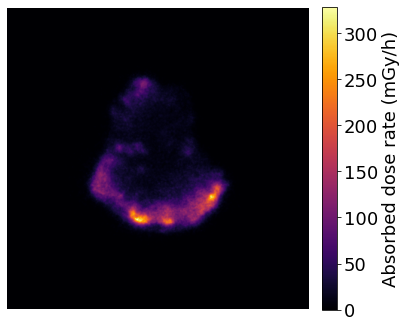

complete:
data\H700\25March



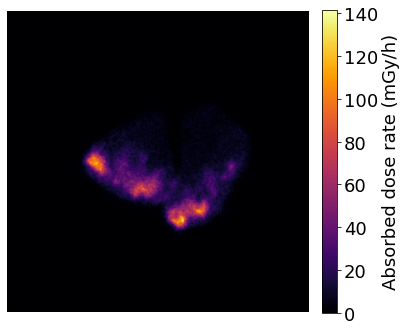

complete:
data\H700\26March



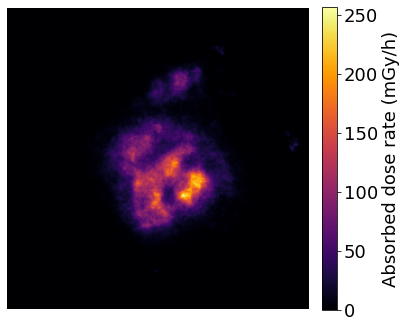

complete:
data\H707\17June



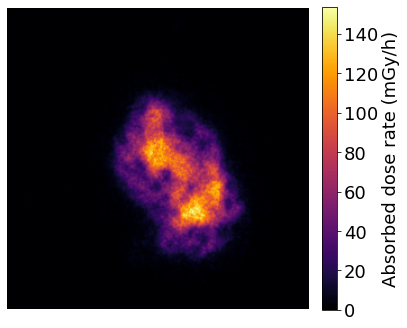

complete:
data\H707\18June



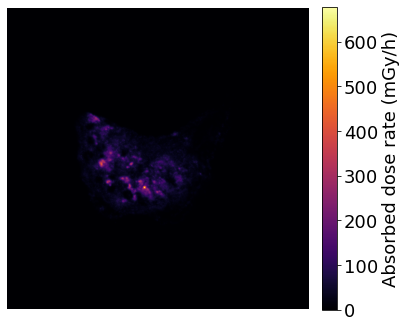

complete:
data\H714\16Sep



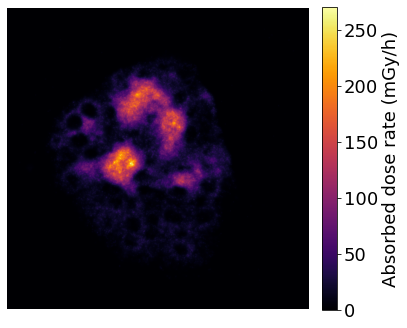

complete:
data\H714\17Sep



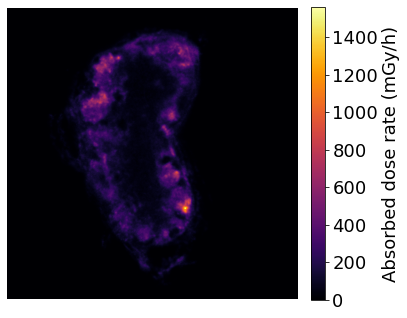

complete:
data\H719\7Oct



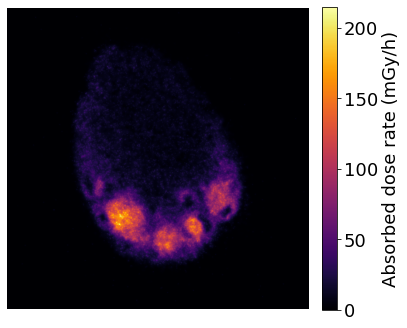

complete:
data\H719\8Oct



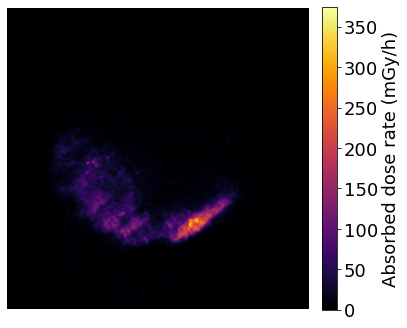

complete:
data\H741\2Dec



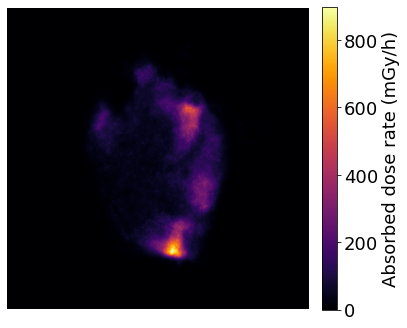

complete:
data\H741\3Dec



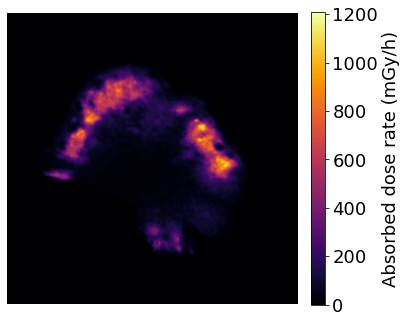

complete:
data\H751\3Mar



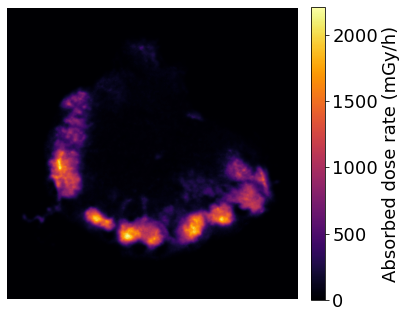

complete:
data\H764\PNNL



In [ ]:
for i in range(len(ssl)):
    imdir = ssl[i]

    astack_mBq = io.imread(os.path.join(imdir, 'aligned', 'imstack.tif'))
    
    # Correct for small errors introduced by transformation
    astack_corr = astack_mBq / (1+a_corr[i])
    
    # Bin the kernel down to match the iQID image resolution.
    study_um_px = np.round(um_per_px[i])
    padded_kernel = dpk.pad_kernel_to_vsize(radial_kernel,
                                                vox_xy=study_um_px,
                                                slice_z=study_slice_z)

    d, m, n = padded_kernel.shape
    binned_kernel = process.bin_ndarray(padded_kernel,
                                        (int(d/study_slice_z),
                                        int(m/study_um_px),
                                        int(n/study_um_px)))
    
    events = astack_corr * efficiency_factor * time_snapshot * 1e-3 # convert mBq > Bq

    # Unit conversions and convolution.
    vox_vol_m = (study_um_px * 1e-6)**2 * (study_slice_z * 1e-6)
    mgy_kernel = dpk.mev_to_mgy(binned_kernel, vox_vol_m)
    mgy_per_hr = convolve(events, mgy_kernel) * 60 * 60

    # Select the dose rate image of the central slice.
    central_slice = mgy_per_hr[len(mgy_per_hr)//2,:,:]
    
    # Visualize
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(central_slice, cmap='inferno')
    ax.axis('off')
    cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
    cbar.set_label('Absorbed dose rate (mGy/h)')
    plt.tight_layout()   
    plt.show()
    
    print('complete:')
    print(ssl[i])
    print('')